In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

# Credit Risk Scoring

In [3]:
!wget $data

--2025-11-07 09:13:17--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.009s  

2025-11-07 09:13:17 (20.3 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [2]:
df=pd.read_csv('CreditScoring.csv')

In [3]:
df.columns=df.columns.str.lower().str.replace(' ', '_')

In [4]:
status_values = {
     1:'ok', 
     2:'default', 
     0:'unk'
}
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)
df.status=df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)

In [5]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [6]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [7]:
for c in ['income', 'assets', 'debt']:
    df[c]=df[c].replace(to_replace=99999999, value=np.nan)

In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [9]:
df=df[df.status != 'unk'].reset_index(drop=True)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [12]:
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

In [13]:
y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values

In [14]:
del df_train['status']
del df_test['status']
del df_val['status']

## Decision Trees

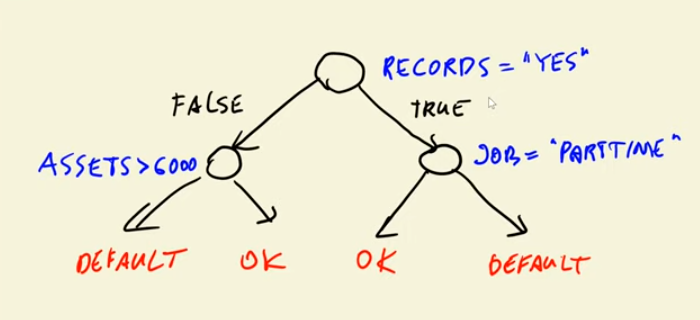

coded with if-else conditions/rules

**pseudo-code** 

    if client has prev 'records' then:
        if client's job is partime then:
            return 'default'
        else:
            if client's assets > X then:
                return 'ok'
            else:
                return 'default'

**these rules/conditions will be learnt by our model from the data, instead of us hardcoding/encoding it**

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [16]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [17]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [18]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [19]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [20]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
# auc on val data
y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on val:{auc}")

# auc on train data 
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print(f"AUC on train:{auc}")

AUC on val:0.7389079944782155
AUC on train:0.7761016984958594


In [22]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



**^^problem of overfitting**

why this happens?

    - Because of the specificity of rules. Ex. one customer passes conditional checks and is classed as 'default'.. the model will memorize this and predict the same status for another person with similar conditions. Especially because the depth of the dree can even be infinite. 

**To counter the depth issue, we can restrict the depth.**

## Decision Tree Algo

In [23]:
data = [[8000, 'default'],
        [2000, 'default'],
        [0, 'default'],
        [5000, 'ok'],
        [5000, 'ok'],
        [4000, 'ok'],
        [9000, 'ok'],
        [3000, 'default']]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example        

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [24]:
ts = [0,2000,3000,4000,5000,8000] #thresholds for ASSETS > T

In [25]:
from IPython.display import display

In [26]:
for t in ts:
    print(t)
    df_left = df_example[df_example.assets <= t]
    df_right = df_example[df_example.assets > t]
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64


#### to understand how good our predictions are - we take a look at `misclassification rate` - aka `Impurity`.

say our t = 4000 

then the split looks like this 

    	assets	status
    1	2000	default
    2	0	default
    5	4000	ok
    7	3000	default

df_left - misclassification rate = 1/4 = 25%

            assets	status
    0	8000	default
    3	5000	ok
    4	5000	ok
    6	9000	ok


df_right - misclassification rate = 1/4 = 25% (how may are wrongly classified -> 1 is okay out of 4)


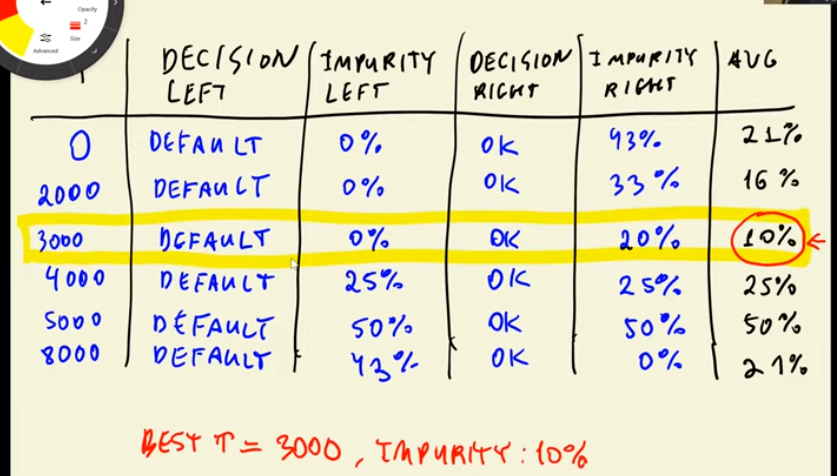

now, let's use two features - assets + debts, 

In [27]:
data = [[8000, 3000,'default'],
        [2000, 1000,'default'],
        [0, 1000,'default'],
        [5000, 1000,'ok'],
        [5000, 1000,'ok'],
        [4000, 1000,'ok'],
        [9000, 500,'ok'],
        [3000, 2000,'default']]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


##### now we split by debt

In [28]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


**so possible thresholds are 500, 1000, 2000**

In [29]:
thresholds = {
    'assets':[0,2000,3000,4000,5000,8000],
    'debt':[500,1000,2000]
}
for feature,ts in thresholds.items():
    print('*******************************')
    for t in ts:
        print(t)
        df_left = df_example[df_example[feature] <= t]
        df_right = df_example[df_example[feature] > t]
        
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
        

*******************************
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64
*******************************
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64


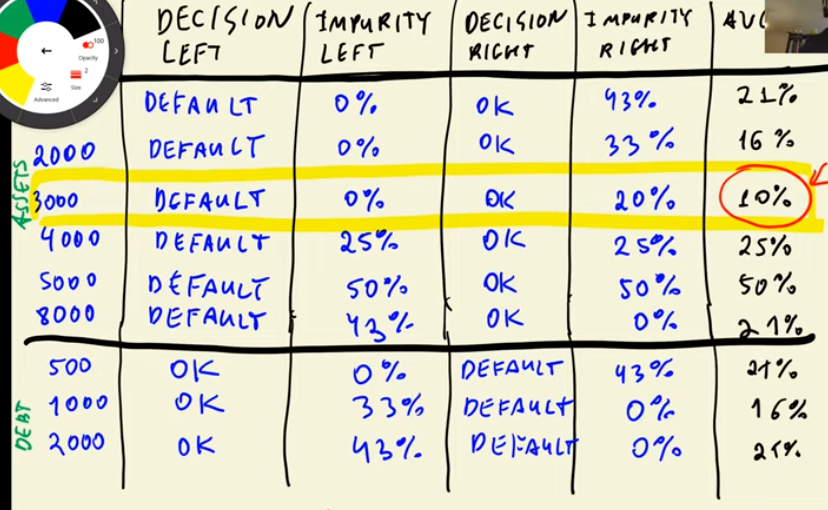

**as we can see, assets with t=3000 is still the best (has least impurity) - so we do our split by assets and not debt**


therefore, 

    for f in features:
        find number of thresholds for f 
        for t in thresholds:
            split dataset using 'F>T' condition
            compute the impurity of this split

    select the condition with the lowest impurity

depth of the tree is an indicator of splits within splits 

ex. if the split for assets > 3000, then left has 3 records, and right has 5 records

    we can further split the right into more left,right pairs
    
    while it doesn't make sense to split when it's only 3,5 but if your dataframe has say 800 records, then left becomes 300 and right becomes 500 in which case, it makes sense to split - this is where `depth` comes into picture. 
    
    we recursively apply splitting but when do we decide to stop?

stopping criterias:

    - group already pure 
    - tree reached depth limit
    - group is too small to split (like above 3,5 example)

**SUMMARY**
  
Decision Tree learning Algo:

    - Find the best split 
    - Stop if MAX_DEPTH is reached 
    - If LEFT is sufficiently large and not pure:
        repeat for left. 
    - If RIGHT is sufficiently large and note pure:
        repeat for right

## Decision Tree Parameter Tuning

- **selecting `max_depth`** - A “split” means a condition on one feature, and each time you add a new condition deeper in the tree, you increase the depth by 1.
Not “per feature overall” — it’s per condition node on any feature.

    So, `max_depth` is how far down you can go/how many questions you can consequently ask before the model starts to overfit (get too specific) 


- **selecting `min_samples_leaf`** - how many samples must be in the final group before it can qualify for a conclusion (ex. let's say we have a group of 20 students and we're assessing something - if only kid is in the final group (end of decision tree) - it's not good enough, so you want at least 3 kids to be in tht group before you make a final deciison.).

    If you let the tree split and split, it might make tiny leaves like:
    
    “People who are 37 years old, earn 60,200, live in ZIP code 94109, and have exactly one late payment”
    — and that leaf only has 2 people in it!
    
    That’s too specific — it’s memorizing instead of learning.
    
    **Therefore, if a potential split makes a group smaller than `min_samples_leaf`, then don't make that split - this prevents overfitting.**



In [30]:
for d in [1,2,3,4,5,6,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d,auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.757
  10 -> 0.695
  15 -> 0.647
  20 -> 0.662
None -> 0.651


**best depth - 4,5,6 (best among the three is still `5`)**

In [31]:
scores = []
for d in [4,5,6,7,10,15,20,None]:
    for l in [1,2,5,10,15,20,100,200,500]: # min_samples_leaf
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=l)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d,l,auc))

In [32]:
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values('auc', ascending=False).head(5)

,max_depth,min_samples_leaf,auc
40,10.0,15,0.790042
49,15.0,15,0.789267
58,20.0,15,0.787314
41,10.0,20,0.785301
67,NaN,15,0.785198


In [33]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

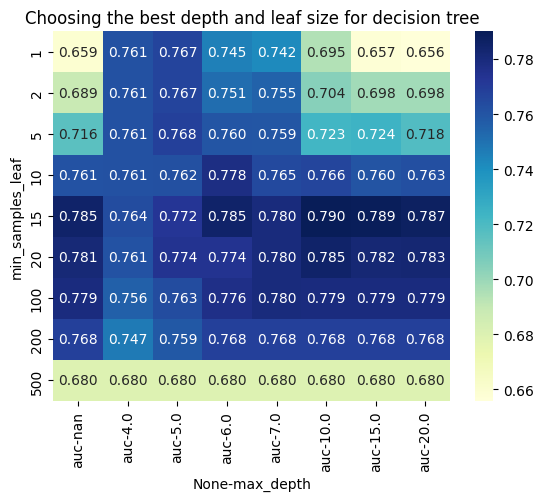

In [34]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Choosing the best depth and leaf size for decision tree')
plt.show()

auc - 10, min_samples_leaf - 15 >> best performance. 

but since auc - 6, and min_samples_leaf - 15 is only 0.04 less, it would still do.  
    

In [35]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train) 

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Ensembles & Random Forest

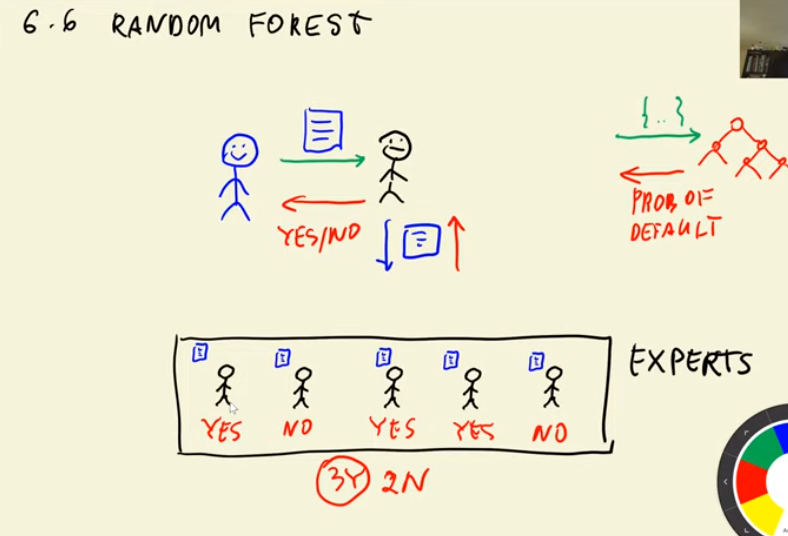

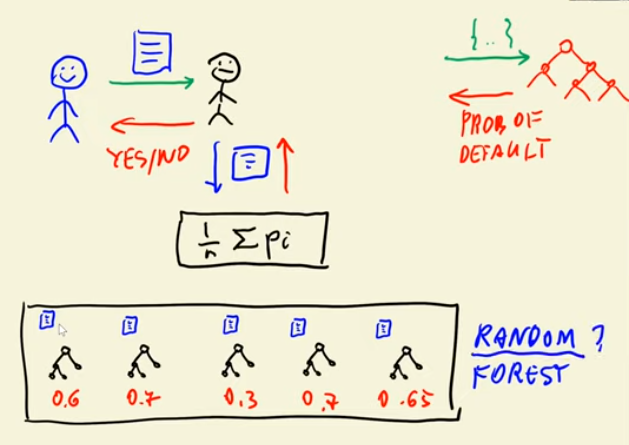

in the above example, **each model gets a unique set of features.**

for the credit risk scoring project, let's say there are three Decision trees, 

    - one with features (assets, debt)
    - another with (assets, price)
    - and the third with (debt,price)

it's called random forest, because each model gets a `random` set of features

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(n_estimators = 10, random_state=1) 
#n_estimators is the number of decision trees you want to train inside your model
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:,1]
auc=roc_auc_score(y_val, y_pred)
auc

0.7744726453706618

Because each tree sees the world a bit differently:

    Each tree gets a random sample of the data (called bootstrapping)
    
    Each tree uses a random subset of features (so they don’t all learn the same thing)

Then, by averaging or voting across many trees:

The random mistakes cancel out

The overall prediction becomes more stable and accurate

In [38]:
scores = []
for n in [1,2,3,4,5,10,15,20,50,100,150,200,250]:
    rf = RandomForestClassifier(n_estimators=n, random_state=1) 
    #n_estimators is the number of decision trees you want to train inside your model
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc=roc_auc_score(y_val, y_pred)
    print("%s -> %.3f" % (n, auc))
    scores.append((n,auc))

1 -> 0.642
2 -> 0.683
3 -> 0.717
4 -> 0.737
5 -> 0.749
10 -> 0.774
15 -> 0.790
20 -> 0.804
50 -> 0.817
100 -> 0.818
150 -> 0.817
200 -> 0.819
250 -> 0.820


In [39]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'auc'])

Text(0, 0.5, 'auc score')

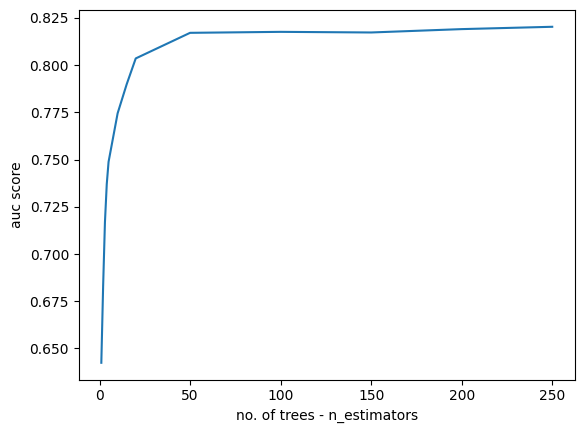

In [40]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel ('no. of trees - n_estimators')
plt.ylabel ('auc score')

it doesn't grow afer 50 i.e the performance doesn't improve

In [41]:
scores = []
for d in [5,10,15]:
    for n in [1,2,3,4,5,10,15,20,50,100,150,200,250]:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1) 
        #n_estimators is the number of decision trees you want to train inside your model
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc=roc_auc_score(y_val, y_pred)
        print("%s, %s -> %.3f" % (d, n, auc))
        scores.append((d,n,auc))

5, 1 -> 0.705
5, 2 -> 0.765
5, 3 -> 0.774
5, 4 -> 0.781
5, 5 -> 0.780
5, 10 -> 0.788
5, 15 -> 0.795
5, 20 -> 0.798
5, 50 -> 0.800
5, 100 -> 0.804
5, 150 -> 0.807
5, 200 -> 0.807
5, 250 -> 0.807
10, 1 -> 0.638
10, 2 -> 0.699
10, 3 -> 0.739
10, 4 -> 0.756
10, 5 -> 0.770
10, 10 -> 0.791
10, 15 -> 0.806
10, 20 -> 0.808
10, 50 -> 0.817
10, 100 -> 0.821
10, 150 -> 0.824
10, 200 -> 0.825
10, 250 -> 0.824
15, 1 -> 0.630
15, 2 -> 0.702
15, 3 -> 0.752
15, 4 -> 0.761
15, 5 -> 0.769
15, 10 -> 0.795
15, 15 -> 0.803
15, 20 -> 0.809
15, 50 -> 0.813
15, 100 -> 0.816
15, 150 -> 0.818
15, 200 -> 0.820
15, 250 -> 0.822


In [42]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores.head()

,max_depth,n_estimators,auc
0,5,1,0.704930
1,5,2,0.765112
2,5,3,0.773964
3,5,4,0.780854
4,5,5,0.779743


Depth=5
Depth=10
Depth=15


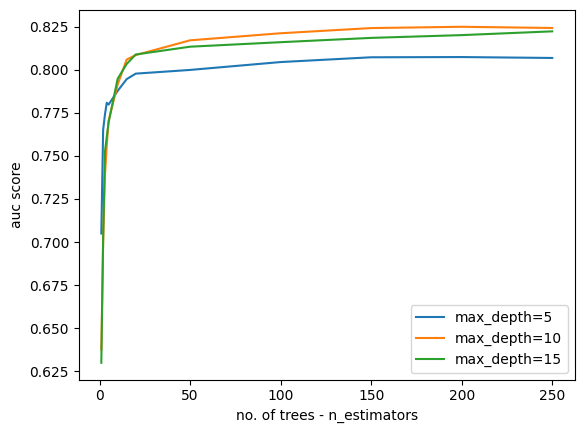

In [43]:
for d in [5,10,15]:
    print(f'Depth={d}')
    df_subset = df_scores[df_scores.max_depth==d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' %d)
    plt.xlabel ('no. of trees - n_estimators')
    plt.ylabel ('auc score')
plt.legend()

**seems max_deth = 10 has the best performance**

**now we look for min_samples_leaf**

In [44]:
scores = []
max_depth=10
for s in [1,3,5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1) 
        #n_estimators is the number of decision trees you want to train inside your model
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc=roc_auc_score(y_val, y_pred)
        #print("%s, %s -> %.3f" % (d, n, auc))
        scores.append((s,n,auc))

In [45]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])

In [46]:
colors=['black', 'red', 'green', 'blue', 'yellow']
zipped = zip([1,3,5,10,50], colors)

Min_Samples_Leaf=1
Min_Samples_Leaf=3
Min_Samples_Leaf=5
Min_Samples_Leaf=10
Min_Samples_Leaf=50


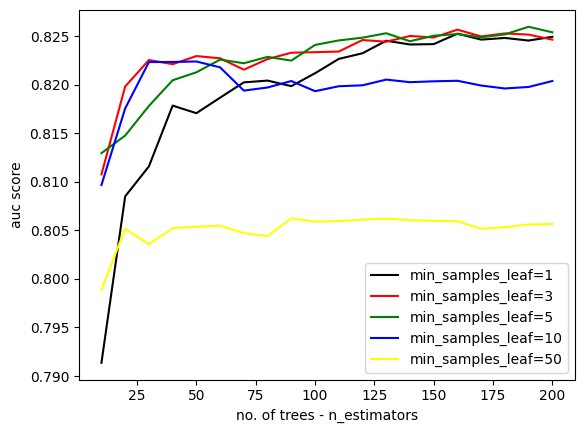

In [47]:
for s,col in zipped:
    print(f'Min_Samples_Leaf={s}')
    df_subset = df_scores[df_scores.min_samples_leaf==s]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=col, label='min_samples_leaf=%d' %s)
    plt.xlabel ('no. of trees - n_estimators')
    plt.ylabel ('auc score')
plt.legend()

    1,3,5 -> are the best 
    10 -> okay 
    50 -> bad

we can go with **3**

In [48]:
max_depth = 10 
min_samples_leaf = 3
scores= []
for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1) 
        #n_estimators is the number of decision trees you want to train inside your model
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc=roc_auc_score(y_val, y_pred)
        #print("%s, %s -> %.3f" % (d, n, auc))
        scores.append((n,auc))

In [49]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores.sort_values('auc', ascending=False).head(1)

,n_estimators,auc
15,160,0.825655


## Gradient Boosting

Boosting is when one model learns from a previous model's errors. It's a sequential process, unlike Radom forest, which is parallel. 

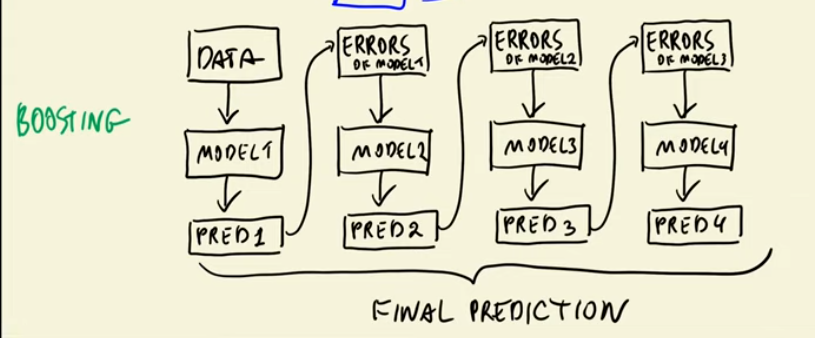

Each model iteration is a 'tree'. 

We use XGBoost package to execute this. 

In [51]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 66.0 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 74.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]━━━ 1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [52]:
import xgboost as xgb

In [57]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features) #datastructure for xgb



In [75]:
xgb_params = {
    'eta': 0.3,                     # learning rate/shrinkage/step size, is by default 0.3. 
    'max_depth' : 6,                # eqv to max_depth
    'min_child_weight' : 1,         # eqv to min_samples_leaf
    'objective': 'binary:logistic', # class and type of the model (here, defaulting, not defaulting)
                                    # can also be used for regrssion, or diff types of classification problems
    'nthreads':8,         # no. of parallel threads used during training per CPU core.
    'seed':1,             # to fix
    'verbosity':1         # 1 - show warnings, 0 - don't show warnings. 
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10) #num_boost_round = how many trees. 

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [08:21:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "nthreads" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [76]:
y_pred = model.predict(dval) #instead of supplying X_val, as we want it in the XGB data structure DMatrix. 

In [74]:
roc_auc_score(y_val, y_pred)

0.8197882105059214

In [82]:
%%capture output 

watchlist = [ (dtrain, 'train'), (dval, 'val') ]
xgb_params = {
    'eta': 0.3,                     # learning rate/shrinkage/step size, is by default 0.3. 
    'max_depth' : 6,                # eqv to max_depth
    'min_child_weight' : 1,         # eqv to min_samples_leaf
    
    'objective': 'binary:logistic', # class and type of the model (here, defaulting, not defaulting)
                                    # can also be used for regrssion, or diff types of classification problems
    'eval_metric':'auc',
    'nthreads':8,         # no. of parallel threads used during training per CPU core.
    'seed':1,             # to fix
    'verbosity':0         # 1 - show warnings, 0 - don't show warnings. 
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5,
                  num_boost_round=200) #num_boost_round = how many trees. 

[15]	<t>train-auc:0.96767<t>	val-auc:0.81993

^^seems to be the best performance.. 

In [85]:
print(output.stdout) # no easy way to extract from model, so we use %%capture output

[0]	train-auc:0.86653	val-auc:0.77999
[5]	train-auc:0.92969	val-auc:0.80822
[10]	train-auc:0.95512	val-auc:0.81115
[15]	train-auc:0.96767	val-auc:0.81993
[20]	train-auc:0.97648	val-auc:0.81877
[25]	train-auc:0.98248	val-auc:0.81520
[30]	train-auc:0.98844	val-auc:0.81613
[35]	train-auc:0.99244	val-auc:0.81453
[40]	train-auc:0.99393	val-auc:0.81407
[45]	train-auc:0.99568	val-auc:0.81392
[50]	train-auc:0.99723	val-auc:0.81276
[55]	train-auc:0.99804	val-auc:0.81299
[60]	train-auc:0.99861	val-auc:0.81244
[65]	train-auc:0.99916	val-auc:0.81197
[70]	train-auc:0.99962	val-auc:0.81243
[75]	train-auc:0.99975	val-auc:0.81152
[80]	train-auc:0.99989	val-auc:0.81359
[85]	train-auc:0.99993	val-auc:0.81193
[90]	train-auc:0.99998	val-auc:0.81038
[95]	train-auc:0.99999	val-auc:0.80871
[100]	train-auc:0.99999	val-auc:0.80842
[105]	train-auc:1.00000	val-auc:0.80778
[110]	train-auc:1.00000	val-auc:0.80764
[115]	train-auc:1.00000	val-auc:0.80722
[120]	train-auc:1.00000	val-auc:0.80750
[125]	train-auc:1.0000

**the above helps us understand overfitting (difference between train and val auc)**

In [103]:
from IPython.display import display

In [110]:
s = output.stdout
line = s.split('\n')
for i in range(0,len(line)):
    
    line = s.split('\n')[i]
    num_iter, train_auc, val_auc = line.split('\t')
    
    num_boost_round = int(num_iter.strip('[]'))
    train_auc = float(train_auc.split(':')[1])
    val_auc = float(val_auc.split(':')[1])
    
    display(num_boost_round, train_auc, val_auc)

0

0.86653

0.77999

5

0.92969

0.80822

10

0.95512

0.81115

15

0.96767

0.81993

20

0.97648

0.81877

25

0.98248

0.8152

30

0.98844

0.81613

35

0.99244

0.81453

40

0.99393

0.81407

45

0.99568

0.81392

50

0.99723

0.81276

55

0.99804

0.81299

60

0.99861

0.81244

65

0.99916

0.81197

70

0.99962

0.81243

75

0.99975

0.81152

80

0.99989

0.81359

85

0.99993

0.81193

90

0.99998

0.81038

95

0.99999

0.80871

100

0.99999

0.80842

105

1.0

0.80778

110

1.0

0.80764

115

1.0

0.80722

120

1.0

0.8075

125

1.0

0.80603

130

1.0

0.80496

135

1.0

0.80422

140

1.0

0.80379

145

1.0

0.8052

150

1.0

0.80561

155

1.0

0.80614

160

1.0

0.80604

165

1.0

0.80637

170

1.0

0.8065

175

1.0

0.80617

180

1.0

0.80567

185

1.0

0.80584

190

1.0

0.80619

195

1.0

0.80587

199

1.0

0.80602

ValueError: not enough values to unpack (expected 3, got 1)

In [178]:
def parse_xgb_output(output):
    results = [] 

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
        columns = ['num_boost', 'train_auc', 'val_auc']
        df = pd.DataFrame(results, columns=columns)

    return df

In [179]:
df_scores = parse_xgb_output(output)

df_scores.sort_values(by='val_auc', ascending=False)

,num_boost,train_auc,val_auc
18,90,0.98770,0.82851
16,80,0.98397,0.82811
19,95,0.98899,0.82775
17,85,0.98547,0.82747
13,65,0.97720,0.82745
12,60,0.97493,0.82736
15,75,0.98202,0.82728
21,105,0.99133,0.82714
20,100,0.99024,0.82711
25,125,0.99476,0.82706


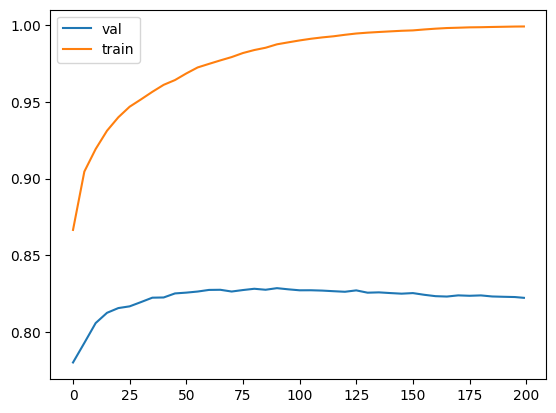

In [180]:
plt.plot(df_scores.num_boost, df_scores.val_auc, label='val')
plt.plot(df_scores.num_boost, df_scores.train_auc, label='train')
plt.legend()
plt.show()

## XGBoost Parameter Tuning

Parameters to be tuned:

    - eta, also known as, step size
    - min_child_weight
    - max_depth

**ETA**

how much weight the second model has when its correcting the predictions of the first model. 

ex. 

   - if weight = 1.0, then all the predictions are used for correction
   - if weight = 0.8, then only 80% of the predictions are used for the correction in the next model.
   - ... and so on.  


In [181]:
scores = {}

In [194]:
%%capture output 

watchlist = [ (dtrain, 'train'), (dval, 'val') ]
xgb_params = {
    'eta': 1.0,                     # learning rate/shrinkage/step size, is by default 0.3. 
    'max_depth' : 6,                # eqv to max_depth
    'min_child_weight' : 1,         # eqv to min_samples_leaf
    
    'objective': 'binary:logistic', # class and type of the model (here, defaulting, not defaulting)
                                    # can also be used for regrssion, or diff types of classification problems
    'eval_metric':'auc',
    'nthreads':8,         # no. of parallel threads used during training per CPU core.
    'seed':1,             # to fix
    'verbosity':0         # 1 - show warnings, 0 - don't show warnings. 
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5,
                  num_boost_round=200) #num_boost_round = how many trees. 

In [195]:
key = 'eta=%s' % (xgb_params['eta'])

scores[key] = parse_xgb_output(output)


In [197]:
scores.keys()

dict_keys(['eta=0.1', 'eta=0.3', 'eta=0.05', 'eta=0.01', 'eta=1.0'])

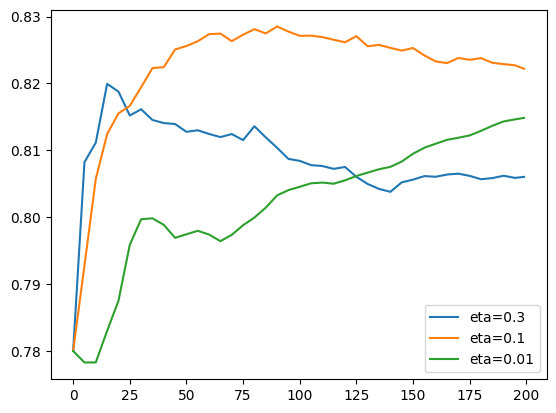

In [205]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_boost, df_score.val_auc, label=eta)
plt.legend()

**lower eta - learns slower, but doesnt overfit**

0.01 - takes forever to learn, because it takes small steps (not suitable because it takes a long time and resources to reach a better auc)

0.1 seems to be in the sweet spot - it needs a few iterations but the performance is also better.

so, we'll go ahead with `eta=0.1`

**order of tuning: (in the lesson)**

- `eta` -> `max_depth` -> `min_child_weight`

**max_depth**

In [220]:
scores = {}

In [233]:
%%capture output 

watchlist = [ (dtrain, 'train'), (dval, 'val') ]
xgb_params = {
    'eta': 0.1,                     
    'max_depth' : 2,                
    'min_child_weight' : 1,         
    'objective': 'binary:logistic',                        
    'eval_metric':'auc',
    'nthreads':8,         
    'seed':1,            
    'verbosity':0         
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5,
                  num_boost_round=200)


In [234]:
key = 'max_depth=%s' % (xgb_params['max_depth'])

scores[key] = parse_xgb_output(output)


In [235]:
scores.keys()

dict_keys(['max_depth=4', 'max_depth=6', 'max_depth=3', 'max_depth=10', 'max_depth=2'])

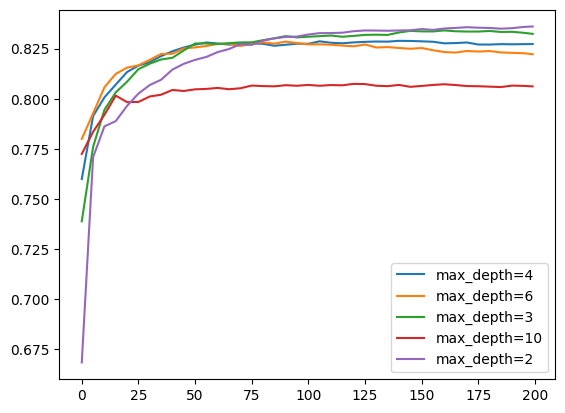

In [236]:
for max_depth, df_scores in scores.items():
    plt.plot(df_scores.num_boost, df_scores.val_auc, label=max_depth)
plt.legend()

**10** : no improvement after reaching peak

In [ ]:
del scores['max_depth=10']

In [240]:
del scores['max_depth=2']

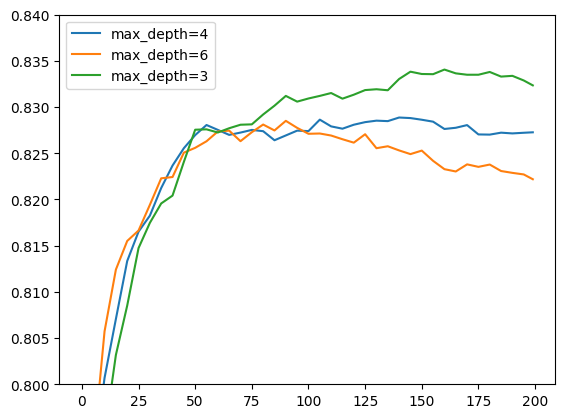

In [242]:
for max_depth, df_scores in scores.items():
    plt.plot(df_scores.num_boost, df_scores.val_auc, label=max_depth)

plt.ylim(0.8,0.84)
plt.legend()

less depth, means it needs more iterations for imporved performance

from the chart, we can conclude that `max_depth=3` is the best depth -> even if it takes time to 

In [244]:
scores = {}

In [254]:
%%capture output 

watchlist = [ (dtrain, 'train'), (dval, 'val') ]
xgb_params = {
    'eta': 0.1,                     
    'max_depth' : 3,                
    'min_child_weight' : 30,         
    'objective': 'binary:logistic',                        
    'eval_metric':'auc',
    'nthreads':8,         
    'seed':1,            
    'verbosity':0         
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5,
                  num_boost_round=200)


In [255]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])

scores[key] = parse_xgb_output(output)


In [256]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=13', 'min_child_weight=30'])

In [258]:
del scores['min_child_weight=13']

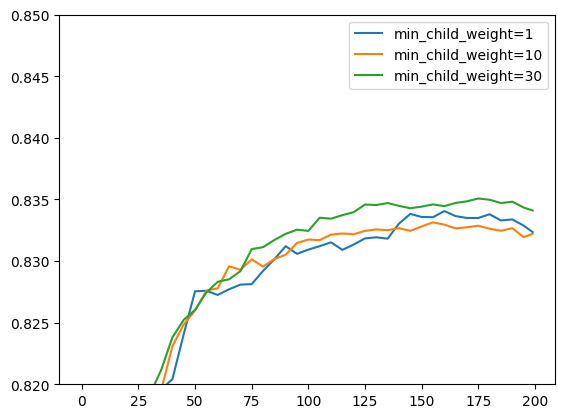

In [260]:
for min_child_weight, df_scores in scores.items():
    plt.plot(df_scores.num_boost, df_scores.val_auc, label=min_child_weight)
plt.ylim(0.82,0.85)
plt.legend()

**because there's negligible difference beteen `min_child_weight=1` and `min_child_weight=30`, we can consider the former - which is default value anyways.** 

**FINAL PARAMETERS**

    ETA - 0.1
    MAX_DEPTH = 3
    MIN_CHILD_WEIGHT = 1 

## Selecting the final model 

- choosing between xgboost, decision tree and random forest.
- training the final model
- saving the model 

In [262]:
# DECISION TREE 

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [263]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.785470804775859

In [264]:
# RANDOM FOREST 

rf = RandomForestClassifier(n_estimators=200, max_depth=10,
                             min_samples_leaf=3, random_state=1) 
       
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [265]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [280]:
xgb_params = {
    'eta': 0.1,                     
    'max_depth' : 3,                
    'min_child_weight' : 30,         
    'objective': 'binary:logistic',                        
    'eval_metric':'auc',
    'nthreads':8,         
    'seed':1,            
    'verbosity':0         
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)


In [281]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8349852268048726

#### training the final model - df_full_train

In [269]:
df_full_train = df_full_train.reset_index(drop=True)

In [272]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [273]:
del df_full_train['status']

In [282]:
# feature matrix for df_full_train 

dicts_full_train = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

# feature matrix for df_test 

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [283]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, 
                         feature_names = list(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names = list(dv.get_feature_names_out()))

In [284]:
xgb_params = {
    'eta': 0.1,                     
    'max_depth' : 3,                
    'min_child_weight' : 30,         
    'objective': 'binary:logistic',                        
    'eval_metric':'auc',
    'nthreads':8,         
    'seed':1,            
    'verbosity':0         
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [285]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8218195591613314

**Our model generalized quite well, very small difference between val and test auc score**